### Group 16 - Yousef Kanj, Elias Antoun, Zhansaya Jumasheva, Ahmad Saad
# Traffic sign classification, Adverserial attacks, and Defence

With self driving cars becoming a popular topic in today's world, alot of problems are required to be solved in order to make the idea a safe and reliable technology. One important task is to be able to see and classify traffic signs correctly for the safety of the passengers and pedestrians. Such a task can be classified as a computer vision task and traffic sign recognition can be solved very reliably using Convolutional Neural Networks.

 A malicious attack on our self driving car may target the data between the sensor and the network, and add small perturbations to the incoming data so that the CNN predicts it incorrectly. Such an attack, part of what we call Adverserial Attacks, is called the Fast Gradient Sign Method (FGSM). Essentially it takes the input data, and adds to it a very small coefficent multiplied by the sign of its gradient of the loss fucntion, so that the original image looks unchanged. This would cause our model to return a wrong prediction.

 It is important for us to study how can we defend against these Adverserial Attacks, since this has real life applications for our safety. The dataset we will be using is the German Traffic Sign Recognition Benchmark (GTSRB) dataset. It has 62000 images of traffic signs classified into 43 classes.

 We will first train a CNN to recognize our dataset, we will then apply FGSM to our input images as part of our Adverserial Attack, and then we will try to defend against the FGSM method and see how well we did.




1. Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


2. Define Functions for Loading and Preprocessing Data

In [2]:
# This function loads each image from its path and makes sure it is resized to it's correct size
def load_and_preprocess_image(image_path, img_size=(32, 32)):
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)  # Here we normalize the pixels to [0,1]
        img = tf.image.resize(img, img_size)
        return img
    # A few images returned errors during reading which is why we added a Try Except statement.
    except tf.errors.NotFoundError:
        raise ValueError(f"Image not found or unable to load: {image_path}")

# This function loads the .csv files which contains the labels to each image path, so that we can associate each label to a loaded image
def load_dataset(dataset_path, csv_file, img_size=(32, 32)):
    df = pd.read_csv(csv_file)
    images = []
    labels = []
    for _, row in df.iterrows():
        image_path = os.path.join(dataset_path, row['Path'])
        images.append(load_and_preprocess_image(image_path, img_size))
        labels.append(row['ClassId'])
    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

3. Load and Split the Dataset

In [3]:
TRAIN_PATH = r"C:\Users\youse\Desktop\FDS final"
TEST_PATH = r"C:\Users\youse\Desktop\FDS final"
TRAIN_CSV = r"C:\Users\youse\Desktop\FDS final\Test.csv"
TEST_CSV = r"C:\Users\youse\Desktop\FDS final\Test.csv"

train_images, train_labels = load_dataset(TRAIN_PATH, TRAIN_CSV)
test_images, test_labels = load_dataset(TEST_PATH, TEST_CSV)

# Split the training data into a training set and a validation set 
train_images, val_images, train_labels, val_labels = train_test_split(train_images.numpy(), train_labels.numpy(), test_size=0.2, random_state=42)

4. Build the CNN Model

Our CNN has an input layer that takes a 32x32 image with 3 color channels.  It then goes through the first convolutional layer of 32 3x3 filter kernels. These kenrels use Rectified Linear Units for activation. The activation functions are essential and are what allow our neural network to work as a non-linear classifier. In our case our activation function is ReLU rakes the max{0,x}. It then goes to a Maxpooling layer which places a 2x2 kernel over the feature map and reduces its dimensions by taking the max value in that 2x2 window.

This feature map is then passed through convoluting layer twice more, with another maxpooling layer in between them. These convolutions serve to recognize more complex features from our input. Finally the feature map is flattened into a 1D array, fed to a dense layer connected 1 to 1 to our flattened array. This dense layer is then connected to another dense 43 neurons, each corresponding to one of the unique classes we have.

We use the Adaptive Moment Estimation (ADAM) optimizer instead of stochastic gradient descent.  

In [4]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(train_labels)), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


5. Train the Model
You can notice that we used a train-validate-test split for our data, the validation split is used at each epoch for the model to try and predict. It is not part of the training set and no direct learning comes as a result of it. It helps tune the model hyper parameters for the next epoch and ensures that our model isn't overfitting. For example, if our model accuracy is high, but our validation accuracy is low, this is a good indicator of overfitting.

Epoch 1/10


316/316 [==============================] - 3s 8ms/step - loss: 2.3695 - accuracy: 0.3810 - val_loss: 1.0101 - val_accuracy: 0.6991
Epoch 2/10
316/316 [==============================] - 2s 7ms/step - loss: 0.6408 - accuracy: 0.8145 - val_loss: 0.4176 - val_accuracy: 0.8844
Epoch 3/10
316/316 [==============================] - 3s 8ms/step - loss: 0.2728 - accuracy: 0.9269 - val_loss: 0.2298 - val_accuracy: 0.9367
Epoch 4/10
316/316 [==============================] - 3s 8ms/step - loss: 0.1671 - accuracy: 0.9538 - val_loss: 0.1584 - val_accuracy: 0.9620
Epoch 5/10
316/316 [==============================] - 3s 8ms/step - loss: 0.1037 - accuracy: 0.9711 - val_loss: 0.1712 - val_accuracy: 0.9557
Epoch 6/10
316/316 [==============================] - 3s 8ms/step - loss: 0.0869 - accuracy: 0.9745 - val_loss: 0.1668 - val_accuracy: 0.9533
Epoch 7/10
316/316 [==============================] - 2s 8ms/step - loss: 0.0558 - accuracy: 0.9843 - val_loss: 0.1121 - val_accuracy: 0.9790
Epoc

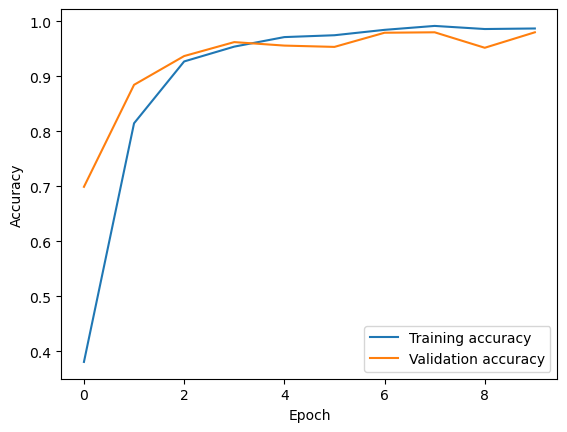

In [5]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


We can see above that overfitting sould not be a concern as the model did quiet well on the validation sets.

6. Create Adversarial Examples Using FGSM

FSGM aims to change the input values of the image very slightly but not enough for it to be detectable by a human.

\begin{align}
\text{FGSM: \  } \  x = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y))
\end{align}

It takes the original image x, and adds to it a small value epsillon, multiplied by the sign of the gradient of the loss function.

In [48]:
# This function returns the sign of our gradient of the loss function for a given image.
def create_adversarial_pattern(input_image, input_label, model):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

np.random.seed(0)

random_indices = tf.constant(np.random.choice(test_images.shape[0], 1000, replace=False))

test_subset = tf.gather(test_images, random_indices)
test_labels_subset = tf.gather(test_labels, random_indices)

# Create adversarial images
epsilon = 0.025
perturbations = create_adversarial_pattern(test_subset, test_labels_subset, model)
adversarial_test_images = test_subset + perturbations * epsilon


7. Evaluate Model Performance on Original and Adversarial Images

We now have the model test our images after FGSM was applied to them.

32/32 [==============================] - 0s 3ms/step - loss: 0.0150 - accuracy: 0.9960
Original Model Accuracy: 99.60%
32/32 [==============================] - 0s 2ms/step - loss: 8.2769 - accuracy: 0.2810
Adversarial Model Accuracy: 28.10%


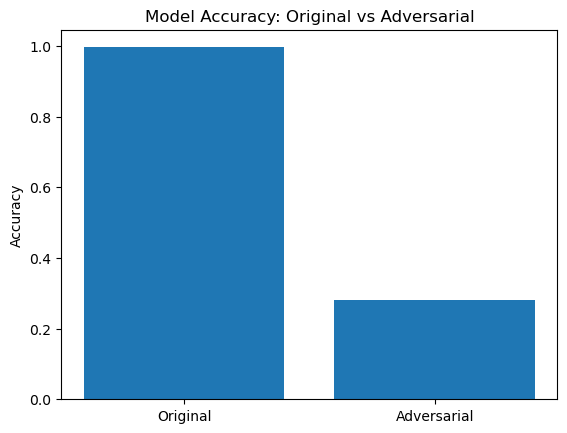

In [7]:
# Original test subset
loss, accuracy_before = model.evaluate(test_subset, test_labels_subset)
print("Original Model Accuracy: {:.2f}%".format(accuracy_before * 100))

# Adversarial test subset
loss, adversarial_accuracy_before = model.evaluate(adversarial_test_images, test_labels_subset)
print("Adversarial Model Accuracy: {:.2f}%".format(adversarial_accuracy_before * 100))

# Plotting comparison
plt.bar(['Original', 'Adversarial'], [accuracy_before, adversarial_accuracy_before])
plt.ylabel('Accuracy')
plt.title('Model Accuracy: Original vs Adversarial')
plt.show()


8. Visualize Some Original and Adversarial Images

Looking at the images below, the images look the same except for some noise added to them.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


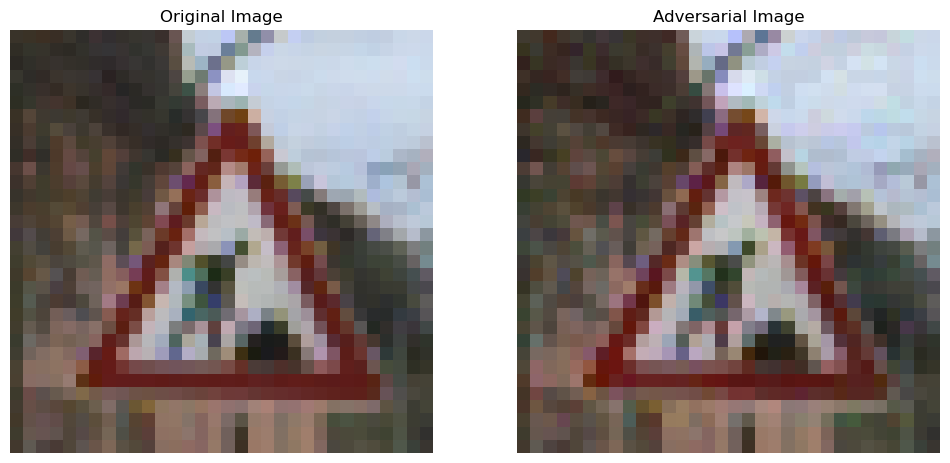

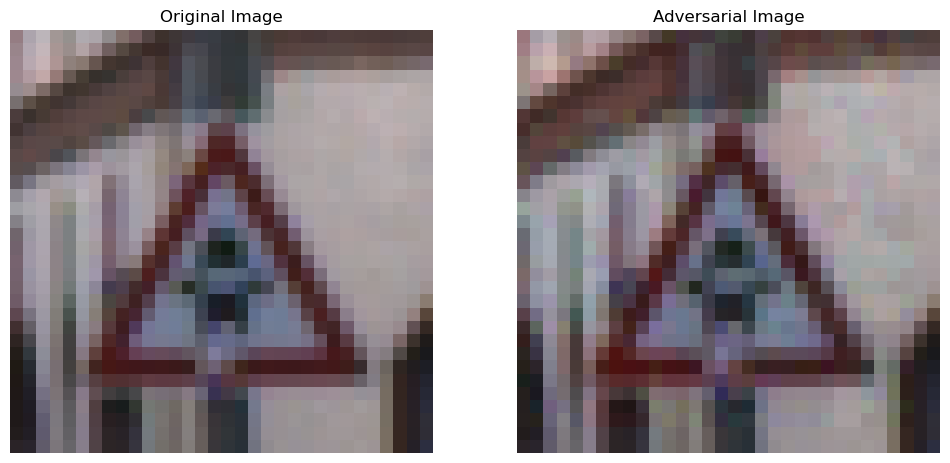

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


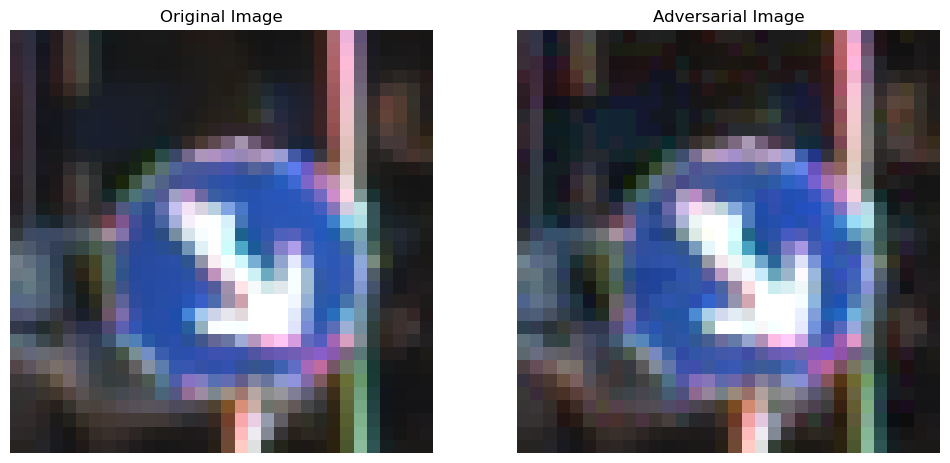

In [8]:
def display_image_pair(original_image, adversarial_image, title1, title2):
    plt.figure(figsize=(12, 6))
    
    # Display original image
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(original_image[0])
    plt.title(title1)
    plt.axis('off')  # Hide the axis

    # Display adversarial image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(adversarial_image[0])
    plt.title(title2)
    plt.axis('off')  # Hide the axis

    plt.show()

# Loop to display each pair of images
for i in range(3):
    display_image_pair(test_subset[i:i+1], adversarial_test_images[i:i+1], "Original Image", "Adversarial Image")

**DEFENSE**

1. Generate Adversarial Training Set

In [9]:
# Convert inputs to tensors
train_subset_tensor = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels_subset_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int64)

# Train with a slightly higher epsilon for more intense but not entirely different perturbations
epsilon = 0.05

# Use the same function that was used before to generate new adversarial data to train the model on
train_perturbations = create_adversarial_pattern(train_subset_tensor, train_labels_subset_tensor, model)
adversarial_train_images = train_subset_tensor + train_perturbations * epsilon



2. Retrain the Model with the Adversarial Training Set

Note that in this step it is important to retrain the model with both the original(unaltered) and the new perturbed images.

In [10]:
# Create 2 different copies of the same model to test 2 possible defenses
# Clone the original model
model_adversarial_trained = tf.keras.models.clone_model(model)
model_adversarial_trained.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_adversarial_trained.set_weights(model.get_weights())

Epoch 1/10
632/632 [==============================] - 5s 7ms/step - loss: 0.8848 - accuracy: 0.7727 - val_loss: 0.2541 - val_accuracy: 0.9291
Epoch 2/10
632/632 [==============================] - 4s 7ms/step - loss: 0.1702 - accuracy: 0.9496 - val_loss: 0.1307 - val_accuracy: 0.9576
Epoch 3/10
632/632 [==============================] - 4s 7ms/step - loss: 0.0742 - accuracy: 0.9778 - val_loss: 0.0936 - val_accuracy: 0.9743
Epoch 4/10
632/632 [==============================] - 4s 7ms/step - loss: 0.0459 - accuracy: 0.9863 - val_loss: 0.0695 - val_accuracy: 0.9786
Epoch 5/10
632/632 [==============================] - 5s 7ms/step - loss: 0.0403 - accuracy: 0.9883 - val_loss: 0.0745 - val_accuracy: 0.9766
Epoch 6/10
632/632 [==============================] - 4s 7ms/step - loss: 0.0318 - accuracy: 0.9900 - val_loss: 0.0774 - val_accuracy: 0.9786
Epoch 7/10
632/632 [==============================] - 5s 7ms/step - loss: 0.0184 - accuracy: 0.9949 - val_loss: 0.0855 - val_accuracy: 0.9743
Epoch 

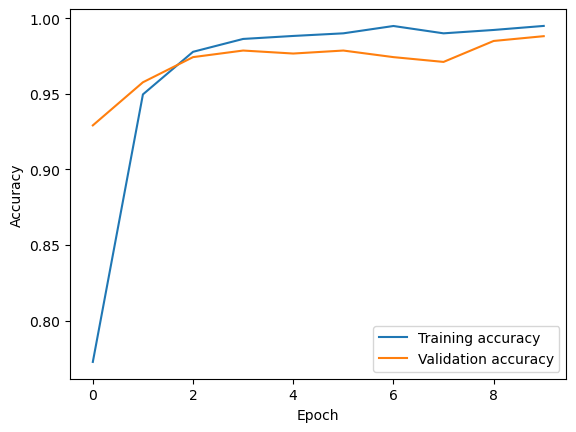

In [11]:
# Concatenate the training images and labels
combined_train_images = np.concatenate([train_images, adversarial_train_images])
combined_train_labels = np.concatenate([train_labels, train_labels_subset_tensor.numpy()])

# Retrain the model
history_adversarial = model_adversarial_trained.fit(
    combined_train_images, 
    combined_train_labels, 
    epochs=10, 
    validation_data=(val_images, val_labels)
)

# Plot the accuracy against epochs
plt.plot(history_adversarial.history['accuracy'], label='Training accuracy')
plt.plot(history_adversarial.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

3. Evaluate the Model Performance After Adversarial Training

 1/32 [..............................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

32/32 [==============================] - 0s 3ms/step - loss: 0.0086 - accuracy: 0.9970
Adversarially Trained Model Accuracy on Original Images: 99.70%
32/32 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9950
Adversarially Trained Model Accuracy on Adversarial Images: 99.50%


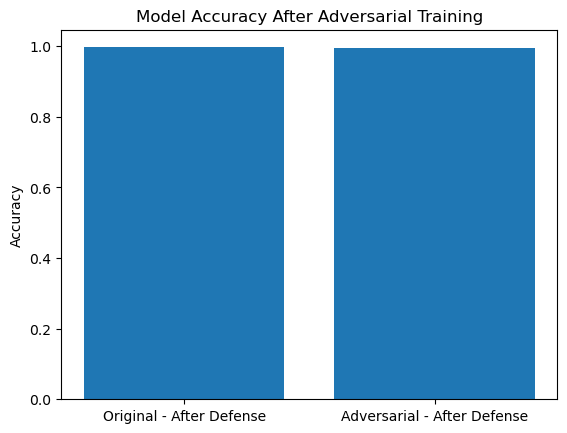

In [12]:
# Evaluate on original test subset
loss, accuracy = model_adversarial_trained.evaluate(test_subset, test_labels_subset)
print("Adversarially Trained Model Accuracy on Original Images: {:.2f}%".format(accuracy * 100))

# Evaluate on adversarial test subset
loss, adversarial_accuracy = model_adversarial_trained.evaluate(adversarial_test_images, test_labels_subset)
print("Adversarially Trained Model Accuracy on Adversarial Images: {:.2f}%".format(adversarial_accuracy * 100))

# Plotting comparison
plt.bar(['Original - After Defense', 'Adversarial - After Defense'], [accuracy, adversarial_accuracy])
plt.ylabel('Accuracy')
plt.title('Model Accuracy After Adversarial Training')
plt.show()

4. Visualize the Effectiveness of the Defense Strategy

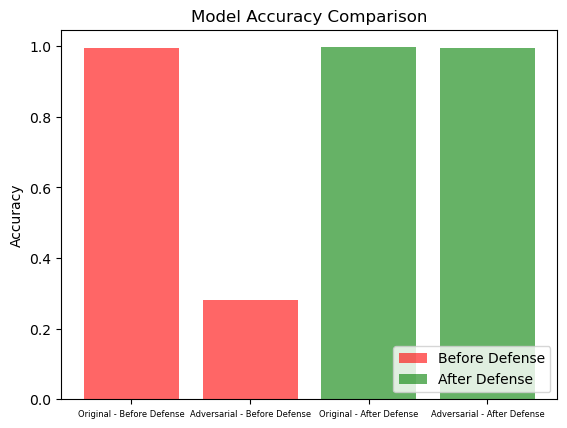

In [13]:
# Before Adversarial Training
plt.bar(['Original - Before Defense', 'Adversarial - Before Defense'], [accuracy_before, adversarial_accuracy_before], alpha=0.6, color='red')

# After Adversarial Training
plt.bar(['Original - After Defense', 'Adversarial - After Defense'], [accuracy, adversarial_accuracy], alpha=0.6, color='green')

plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend(['Before Defense', 'After Defense'], loc='lower right')
plt.xticks(fontsize=6)
plt.show()


Defense (Prevention) Method 2: Feature Squeezing

In [41]:
def create_model():
    model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(train_labels)), activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

def train_teacher_model(train_images, train_labels, epochs=5):
    teacher_model = create_model()
    teacher_model.fit(train_images, train_labels, epochs=epochs)
    return teacher_model

def train_student_model(teacher_model, train_images, train_labels, temperature=5, epochs=5):
    # Create a new model with the same architecture
    student_model = create_model()

    # Modify the teacher model to output softened probabilities
    logits = teacher_model.layers[-2].output  # Assuming second last layer outputs logits
    softened_logits = tf.keras.layers.Lambda(lambda x: x / temperature)(logits)
    softened_probs = tf.keras.layers.Softmax()(softened_logits)
    teacher_with_temp = tf.keras.Model(inputs=teacher_model.input, outputs=softened_probs)


    # Train the student model using the outputs of the teacher model
    teacher_with_temp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    teacher_probs = teacher_with_temp.predict(train_images)

    student_model.fit(train_images, teacher_probs, epochs=epochs)
    train_labels_categorical = tf.keras.utils.to_categorical(train_labels, num_classes=len(np.unique(train_labels)))

    # Rest of your code for training the student model
    student_model.fit(train_images, train_labels_categorical, epochs=epochs)
    return student_model

# Assuming train_images and train_labels are available
teacher_model = train_teacher_model(train_images, train_labels, epochs=5)

# Train the student model using the teacher model
student_model = train_student_model(teacher_model, train_images, train_labels, temperature=5, epochs=5)

# Now, you can evaluate the student_model on your test set


Epoch 1/5
316/316 [==============================] - 3s 7ms/step - loss: 2.1920 - accuracy: 0.4112
Epoch 2/5
316/316 [==============================] - 2s 6ms/step - loss: 0.5044 - accuracy: 0.8554
Epoch 3/5
316/316 [==============================] - 2s 7ms/step - loss: 0.2071 - accuracy: 0.9437
Epoch 4/5
316/316 [==============================] - 2s 7ms/step - loss: 0.1201 - accuracy: 0.9662
Epoch 5/5
316/316 [==============================] - 1s 3ms/step
Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "c:\Users\youse\anaconda3\lib\runpy.py", line 196, in _run_module_as_main

  File "c:\Users\youse\anaconda3\lib\runpy.py", line 86, in _run_code

  File "c:\Users\youse\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\youse\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\youse\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "c:\Users\youse\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start

  File "c:\Users\youse\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever

  File "c:\Users\youse\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once

  File "c:\Users\youse\anaconda3\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\youse\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue

  File "c:\Users\youse\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one

  File "c:\Users\youse\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell

  File "c:\Users\youse\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "c:\Users\youse\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute

  File "c:\Users\youse\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell

  File "c:\Users\youse\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell

  File "c:\Users\youse\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell

  File "c:\Users\youse\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\youse\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async

  File "c:\Users\youse\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes

  File "c:\Users\youse\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code

  File "C:\Users\youse\AppData\Local\Temp\ipykernel_30936\4156406038.py", line 49, in <module>

  File "C:\Users\youse\AppData\Local\Temp\ipykernel_30936\4156406038.py", line 38, in train_student_model

  File "c:\Users\youse\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\youse\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\youse\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\youse\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\youse\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\youse\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1151, in train_step

  File "c:\Users\youse\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss

  File "c:\Users\youse\anaconda3\lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Users\youse\anaconda3\lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Users\youse\anaconda3\lib\site-packages\keras\src\losses.py", line 270, in call

  File "c:\Users\youse\anaconda3\lib\site-packages\keras\src\losses.py", line 2454, in sparse_categorical_crossentropy

  File "c:\Users\youse\anaconda3\lib\site-packages\keras\src\backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,43] and labels shape [2048]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_384065]

In [51]:
import tensorflow as tf
from tensorflow.keras import models, layers

def create_obfuscated_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(np.unique(train_labels)), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def add_gradient_obfuscation(model, rate=0.5):
    """
    Adds gradient obfuscation to the model by randomly setting gradients to zero.
    """
    def custom_gradient_function(grads, vars):
        mask = tf.cast(tf.random.uniform(tf.shape(grads)) > rate, grads.dtype)
        return [g * mask for g in grads], vars

    model.optimizer.get_gradients = custom_gradient_function

    return model

# Create and train the model
obfuscated_model = create_obfuscated_model()
obfuscated_model = add_gradient_obfuscation(obfuscated_model, rate=0.95)  # 50% of gradients will be masked
obfuscated_model.fit(train_images, train_labels, epochs=5)

# This function returns the sign of our gradient of the loss function for a given image.
def create_adversarial_pattern(input_image, input_label, model):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = obfuscated_model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

np.random.seed(10)

ri = tf.constant(np.random.choice(test_images.shape[0], 1000, replace=False))

test_subset = tf.gather(test_images, ri)
test_labels_subset = tf.gather(test_labels, ri)

# Create adversarial images
epsilon = 0.025
perturbations = create_adversarial_pattern(test_subset, test_labels_subset, obfuscated_model)
adversarial_test_images = test_subset + perturbations * epsilon


# Evaluate the model
loss, accuracy = obfuscated_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {accuracy*100:.2f}%")

loss, accuracy = obfuscated_model.evaluate(adversarial_test_images, test_labels_subset)
print(f"Test accuracy: {accuracy*100:.2f}%")


Epoch 1/5
316/316 [==============================] - 3s 6ms/step - loss: 2.1739 - accuracy: 0.4227
Epoch 2/5
316/316 [==============================] - 2s 7ms/step - loss: 0.5195 - accuracy: 0.8451
Epoch 3/5
316/316 [==============================] - 2s 7ms/step - loss: 0.2266 - accuracy: 0.9372
Epoch 4/5
316/316 [==============================] - 2s 7ms/step - loss: 0.1372 - accuracy: 0.9611
Epoch 5/5
395/395 [==============================] - 1s 3ms/step - loss: 0.0596 - accuracy: 0.9864
Test accuracy: 98.64%
32/32 [==============================] - 0s 3ms/step - loss: 6.4714 - accuracy: 0.2900
Test accuracy: 29.00%
